In [1]:
from sklearn.metrics import confusion_matrix
import pandas as pd
from torch.utils.data import DataLoader
import numpy as np
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from PIL import Image
from torchvision import models
from torchvision.models import ResNet18_Weights
import numpy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd
from torch.utils import data
import numpy as np

def getData(mode):
    if mode == 'train':
        img = pd.read_csv('train_img.csv', header=None)
        label = pd.read_csv('train_label.csv', header=None)
        return np.squeeze(img.values), np.squeeze(label.values)
    else:
        img = pd.read_csv('test_img.csv', header=None)
        label = pd.read_csv('test_label.csv', header=None)
        return np.squeeze(img.values), np.squeeze(label.values)

class RetinopathyLoader(data.Dataset):
    def __init__(self, root, mode):
        self.root = root
        self.img_name, self.label = getData(mode)
        self.mode = mode
        print("> Found %d images..." % (len(self.img_name)))

    def __len__(self):
        return len(self.img_name)

    def __getitem__(self, index):
        label = self.label[index]
        img_id = self.img_name[index]
        img_path = self.root+str(img_id)+".jpeg"
        img = np.array(Image.open(img_path))
        img = np.transpose(img,(2,0,1))
        img = img.astype('float32')
        return img, label

In [3]:
test_set = RetinopathyLoader('./data/','test')
test_loader = DataLoader(test_set, batch_size=8)
train_set = RetinopathyLoader('./data/','train')
train_loader = DataLoader(train_set, batch_size=8)

> Found 7026 images...
> Found 28100 images...


In [4]:
model = models.resnet18()
model.fc = nn.Linear(512, 5)

In [4]:
model = models.resnet50()
model.fc = nn.Linear(2048, 5)

In [5]:
model.load_state_dict(torch.load('80/50nopre/ResNet50_nopre_10s.pth'))

<All keys matched successfully>

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
Epochs = 5
batch_size = 8
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.0001, weight_decay=1e-5)

In [7]:
py = []
testp = 0
model.eval()
for timg,tlab in tqdm(test_loader):

    timg, tlab = timg.to(device), tlab.to(device)
    with torch.no_grad():
        predd = model(timg)
    py.extend(predd.argmax(dim=-1))
    loss = criterion(predd,tlab)
    acc = (predd.argmax(dim=-1) == tlab.to(device)).float().mean()
    testp += acc*len(tlab)


  0%|          | 0/879 [00:00<?, ?it/s]

In [8]:
testp/7026

tensor(0.7284, device='cuda:0')

In [9]:
pred = np.array(torch.tensor(py,device='cpu'))

In [10]:
y_true = np.squeeze(pd.read_csv('test_label.csv', header=None))

In [11]:
y_true = y_true.to_numpy()

In [12]:
np.set_printoptions(formatter={'float': '{: .2f}'.format})

In [13]:
mat_con = confusion_matrix(y_true, pred,labels=[0,1,2,3,4])
mat_con = mat_con.astype('float') / mat_con.sum(axis=1)[:, np.newaxis]

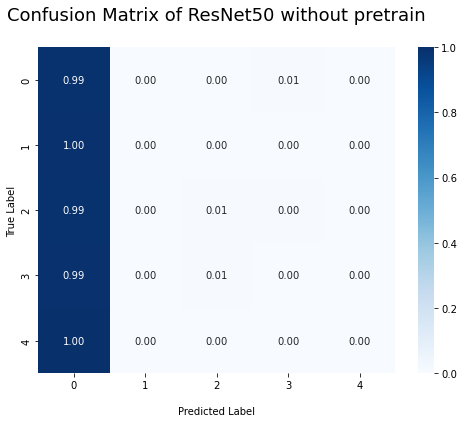

In [15]:
ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(mat_con, annot=True, cmap='Blues',fmt='.2f')
ax.set_title('Confusion Matrix of ResNet50 without pretrain\n',fontsize = 18);
ax.set_xlabel('\nPredicted Label')
ax.set_ylabel('True Label');
## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([0,1,2,3,4])
ax.yaxis.set_ticklabels([0,1,2,3,4])
## Display the visualization of the Confusion Matrix.
plt.show()